## ==============================
## Client Product Recommendation & Market Insight Generation
## ==============================

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import joblib

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from scipy.stats import ttest_ind

# ------------------------------
# 1. Load Data
# ------------------------------

In [24]:
df = pd.read_csv("data/client_data.csv")

In [25]:
print("Initial Data Shape:", df.shape)
print(df.head())

Initial Data Shape: (10, 7)
   client_id  age  income  transactions_last_6m  avg_transaction_value  \
0        101   35   75000                    42                   3200   
1        102   28   45000                    18                   1500   
2        103   50  120000                    65                   5200   
3        104   41   62000                    30                   2800   
4        105   30   52000                    22                   1900   

   credit_score  product_interested  
0           720                   1  
1           680                   0  
2           780                   1  
3           700                   0  
4           690                   0  


In [26]:
print("Initial Data Shape:", df.shape)
print(df.tail())

Initial Data Shape: (10, 7)
   client_id  age  income  transactions_last_6m  avg_transaction_value  \
5        106   45   98000                    55                   4100   
6        107   26   40000                    15                   1200   
7        108   38   85000                    48                   3600   
8        109   34   58000                    27                   2100   
9        110   52  140000                    72                   6000   

   credit_score  product_interested  
5           740                   1  
6           650                   0  
7           730                   1  
8           705                   0  
9           800                   1  


# ------------------------------
# 2. Data Cleaning
# ------------------------------

In [41]:
df.drop_duplicates(inplace=True)
df.fillna(df.median(), inplace=True)


# ------------------------------
# 3. Feature / Target Split
# ------------------------------

In [42]:
X = df.drop(columns=["client_id", "product_interested"])
y = df["product_interested"]

# ------------------------------
# 4. Hypothesis Testing
# Hypothesis: Clients with higher income are more likely
# to be interested in the product
# ------------------------------

In [43]:
interested = df[df["product_interested"] == 1]["income"]
not_interested = df[df["product_interested"] == 0]["income"]


In [44]:
t_stat, p_value = ttest_ind(interested, not_interested)

In [45]:
print("\nHypothesis Test (Income vs Interest)")
print("T-statistic:", t_stat)
print("P-value:", p_value)


Hypothesis Test (Income vs Interest)
T-statistic: 4.181758063372102
P-value: 0.0030722151091174387


In [46]:
if p_value < 0.05:
    print("Result: Statistically significant difference ✅")
else:
    print("Result: No significant difference ❌")

Result: Statistically significant difference ✅


# ------------------------------
# 5. Train-Test Split
# ------------------------------

In [47]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# ------------------------------
# 6. Feature Scaling
# ------------------------------

In [48]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ------------------------------
# 7. Model Training
# ------------------------------

In [49]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=4,
        eval_metric="logloss"
    )
}

results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    probas = model.predict_proba(X_test_scaled)[:, 1]

    auc = roc_auc_score(y_test, probas)
    results[name] = auc

    print(f"\n{name}")
    print(classification_report(y_test, preds))
    print("ROC-AUC:", auc)


Logistic Regression
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         1

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3

ROC-AUC: 1.0

Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         1

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3

ROC-AUC: 1.0

XGBoost
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.33      1.00      0.50         1

    accuracy                           0.33         3
   macro avg       0.17      0.50      0.25         3
wei

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


# ------------------------------
# 8. Select Best Model
# ------------------------------

In [50]:
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]

print("\nBest Model:", best_model_name)


Best Model: Logistic Regression


# Save model

In [51]:
joblib.dump(best_model, "model/trained_model.pkl")
joblib.dump(scaler, "model/scaler.pkl")

['model/scaler.pkl']

# ------------------------------
# 9. SHAP Explainability
# ------------------------------

In [52]:
explainer = shap.Explainer(best_model, X_train_scaled)
shap_values = explainer(X_test_scaled)

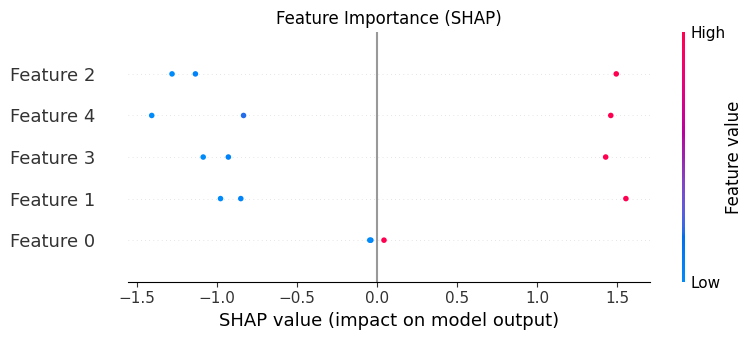

In [53]:
shap.summary_plot(shap_values, X_test, show=False)
plt.title("Feature Importance (SHAP)")
plt.tight_layout()
plt.show()


# ------------------------------
# 10. Market Insight Generation
# ------------------------------

In [54]:
def generate_market_insights(model, data, feature_names):
    importances = model.feature_importances_
    insights = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importances
    }).sort_values(by="Importance", ascending=False)

    top_features = insights.head(3)

    insights_text = "Market Insights:\n"
    for _, row in top_features.iterrows():
        insights_text += f"- {row['Feature']} strongly influences client interest.\n"

    return insights_text

if hasattr(best_model, "feature_importances_"):
    insights = generate_market_insights(
        best_model,
        X_train_scaled,
        X.columns
    )
    print("\n" + insights)

print("\nPipeline executed successfully ✅")


Pipeline executed successfully ✅
